# California Housing Dataset

Preprocessing housing data:

In [5]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

In [6]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


 Stratified test and training sets based on different income categories:

In [10]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

Handling missing values:

In [12]:
X_raw.shape

(16512, 9)

In [15]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [17]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


Fill the missing values in the numerical features (everything except ocean_proximity) with the median of the corresponding feature

In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

X_raw_num = X_raw.drop('ocean_proximity', axis = 1)

imputer.fit(X_raw_num)
X = imputer.transform(X_raw_num)
X =  pd.DataFrame(X,columns = X_raw_num.columns, index =X_raw_num.index)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


Handling categorical features

Transform the ocean_proximity feature to integers and one-hot vectors

In [20]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
X_raw_cat_ord = ord_encoder.fit_transform(X_raw[["ocean_proximity"]])
X_ordcat =  pd.DataFrame(X_raw_cat_ord,columns = ["ocean_proximity"], index =X_raw_num.index)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
X_raw_cat_onehot = onehot_encoder.fit_transform(X_raw[["ocean_proximity"]])
column_name = onehot_encoder.get_feature_names(["ocean_proximity"])
X_onehotcat =  pd.DataFrame(X_raw_cat_onehot.todense(),columns = column_name)
X_onehotcat.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0


Feature scaling

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In min-max scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In standardization, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

sklearn.preprocessing.MinMaxScaler class and sklearn.preprocessing.StandardScaler class to scale the numerical features using min-max scaling and standardization

In [21]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
X_raw_num = X_raw.drop('ocean_proximity', axis = 1)
X_mm = minmaxscaler.fit_transform(X_raw_num)
X_mm =  pd.DataFrame(X_mm,columns = X_raw_num.columns, index =X_raw_num.index)


from sklearn.preprocessing import StandardScaler
stscaler = StandardScaler()
X_raw_num = X_raw.drop('ocean_proximity', axis = 1)
X_st = stscaler.fit_transform(X_raw_num)
X_st =  pd.DataFrame(X_st,columns = X_raw_num.columns, index =X_raw_num.index)

Transformation pipelines

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's Pipeline class provides a systematic way of "packaging" such a sequence of transformations.



In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([('imputer',SimpleImputer(strategy= 'median')),('std_scaler',StandardScaler())])
num_attribs = list(X_raw_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num",num_pipeline,num_attribs),("cat",OneHotEncoder(),cat_attribs)])
X = full_pipeline.fit_transform(X_raw)
col = list(X_raw_num.columns) + list(column_name)
X = pd.DataFrame(X,columns = col, index =X_raw_num.index)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


Fine-tuning models

(a) Linear regression



In [25]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
fitted_val = lin_reg.predict(X)
fit_val = pd.DataFrame(fitted_val,columns = ['fitted'], index =y)
fit_val.head(10)

,fitted
median_house_value,
72100.0,88983.148064
279600.0,305351.353850
82700.0,153334.711835
112500.0,184302.551621
238300.0,246840.189888
165700.0,208983.681348
412300.0,375046.020673
349600.0,270259.898592
181300.0,153462.625157


 RMSE and MAE

In [26]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y,fitted_val)
lin_rmse = np.sqrt(lin_mse)
print('rmse: ',lin_rmse)

from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y,fitted_val)
print('mae: ',lin_mae)

rmse:  69050.56219504567
mae:  49905.329442715316


 Cross validation
 
 We evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg,X,y,scoring="neg_mean_squared_error",cv =10)
linreg_rmse_scores = np.sqrt(-scores)


def display_scores(scores):
    print("Scores:",scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

    
display_scores(linreg_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494766
Standard Deviation: 2372.07079105592


Alternatives to linear regression

Let us consider fitting two alternative models, namely, decision trees and random forests.

In [28]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [30]:
dt_reg.predict(X[:10])

array([ 72100., 279600.,  82700., 112500., 238300., 165700., 412300.,
       349600., 181300., 500001.])

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [32]:
rf_reg.predict(X[:10])

array([ 81652.52309416, 312816.43220775, 103956.26879436, 145669.10673902,
       254963.91541844, 223471.15507845, 359454.5338993 , 261250.07064825,
       178062.03642388, 152509.12871198])

In-sample performance of the decision tree and the random forest using RMSE on the training set

Out-of-sample performance by 10-fold cross validation 

In [35]:
# in-sample

print('rmse- linear regression - in sample: ',lin_rmse)

fitted_val_dt = dt_reg.predict(X)
dt_reg_mse = mean_squared_error(y,fitted_val_dt)
dt_rmse = np.sqrt(dt_reg_mse)
print('\n rmse- decision tree - in sample: ',dt_rmse)

fitted_val_rf = rf_reg.predict(X)
rf_reg_mse = mean_squared_error(y,fitted_val_rf)
rf_rmse = np.sqrt(rf_reg_mse)
print('\n rmse- RandomForest - in sample: ',rf_rmse)


#out-of-sample

print('\n Linear Regression- out of sample \n')
display_scores(linreg_rmse_scores)

tree_scores = cross_val_score(dt_reg,X,y,scoring="neg_mean_squared_error",cv =10)
tree_rmse_scores = np.sqrt(-tree_scores)
print('\n Decision Tree- out of sample \n')
display_scores(tree_rmse_scores)


forest_scores = cross_val_score(rf_reg,X,y,scoring="neg_mean_squared_error",cv =10)
forest_rmse_scores = np.sqrt(-forest_scores)

print('\n Random Forest- out of sample \n')
display_scores(forest_rmse_scores)

rmse- linear regression - in sample:  69050.56219504567

 rmse- decision tree - in sample:  0.0

 rmse- RandomForest - in sample:  66750.70697525762

 Linear Regression- out of sample 

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494766
Standard Deviation: 2372.07079105592

 Decision Tree- out of sample 

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard Deviation: 2296.288087393378

 Random Forest- out of sample 

Scores: [70666.17468232 65975.4104431  63466.98553521 71762.08084765
 65644.92773928 70198.63516218 69549.01504688 68795.8612658
 65340.03824595 68660.17724972]
Mean: 68005.93062180877
Standard Deviation: 2585.2080431468353


Choosing optimal values of hyperparameters using cross validation

Most ML algorithms have hyperparameters. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely bootstrap, n_estimators, and max_depth. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance



In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'bootstrap': [True, False],'n_estimators': [50, 100, 200], 'max_depth': [5, 20, 40]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=4,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [5, 20, 40],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [37]:
print(grid_search.best_params_)
print(np.sqrt(-grid_search.best_score_))


{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}
50271.12629517273


In [39]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'bootstrap': [True, False],   
    'n_estimators': randint(low=50, high=200),
    'max_depth': randint(low=5, high=40),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,n_jobs=-1)
rnd_search.fit(X, y)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002514CC10D30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002514CC107F0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [40]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

print(rnd_search.best_params_)

print(np.sqrt(-rnd_search.best_score_))


50631.36528915277 {'bootstrap': True, 'max_depth': 33, 'n_estimators': 64}
52340.8946928581 {'bootstrap': True, 'max_depth': 12, 'n_estimators': 70}
50380.030436623914 {'bootstrap': True, 'max_depth': 23, 'n_estimators': 124}
50273.28602841223 {'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}
67447.74692166447 {'bootstrap': False, 'max_depth': 28, 'n_estimators': 180}
68465.03714105087 {'bootstrap': False, 'max_depth': 6, 'n_estimators': 137}
67525.4930600352 {'bootstrap': False, 'max_depth': 34, 'n_estimators': 87}
67476.1281683955 {'bootstrap': False, 'max_depth': 25, 'n_estimators': 107}
67520.0131623892 {'bootstrap': False, 'max_depth': 29, 'n_estimators': 98}
50609.391799744895 {'bootstrap': True, 'max_depth': 32, 'n_estimators': 64}
66076.51935679585 {'bootstrap': False, 'max_depth': 7, 'n_estimators': 100}
50362.85253370906 {'bootstrap': True, 'max_depth': 25, 'n_estimators': 122}
50319.065489304085 {'bootstrap': True, 'max_depth': 22, 'n_estimators': 181}
50812.40558997

Evaluating your final model using the test set

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. 


In [41]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

#only transforming the data
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47074.669205115606


Evaluating final model using the test set

In [42]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

#only transforming the data
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47074.669205115606


In [43]:
from sklearn.preprocessing import PolynomialFeatures
num_pipeline = Pipeline([('imputer',SimpleImputer(strategy= 'median')),('poly',PolynomialFeatures(degree = 3)),('std_scaler',StandardScaler())])
num_attribs = list(X_raw_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num",num_pipeline,num_attribs),("cat",OneHotEncoder(),cat_attribs)])
X_poly = full_pipeline.fit_transform(X_raw)
X_poly = pd.DataFrame(X_poly, index =X_raw_num.index)

In [44]:
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly,y)

LinearRegression()

In [45]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
ridge_reg.fit(X_poly,y)

Ridge(alpha=1, solver='cholesky')

Learning curves

Obtain learning curves for the linear regression model, the polynomial regression model, and the ridge regression model

In [46]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 10)
    train_errors,val_errors = [], []
     
    for m in np.arange(1,len(X_train),1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
        
    plt.plot(np.sqrt(train_errors),"r-+",linewidth=2,label = 'train')
    plt.plot(np.sqrt(val_errors),"b-",linewidth=3,label = 'val')
    plt.axhline(y = max(np.sqrt(train_errors)),linewidth=1, color='g',linestyle = 'dashed')
    plt.axhline(y = min(np.sqrt(val_errors)),linewidth=1, color='y',linestyle = 'dashed')
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    print(f"max train error {max(np.sqrt(train_errors))}")
    print(f"min val error {min(np.sqrt(val_errors))}")    

max train error 69939.29798791441
min val error 68628.29545859668


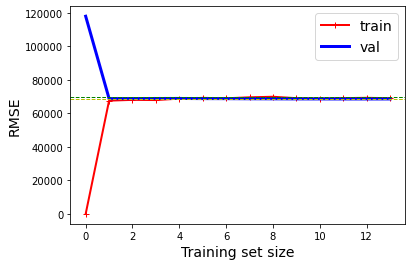

In [47]:
plot_learning_curves(lin_reg,X,y)

max train error 58251.6957892753
min val error 61904.32496642927


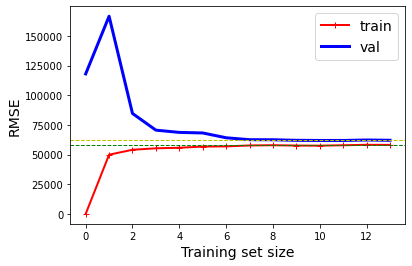

In [48]:
plot_learning_curves(lin_reg_poly,X_poly,y)

max train error 60110.3120677587
min val error 60768.87788738953


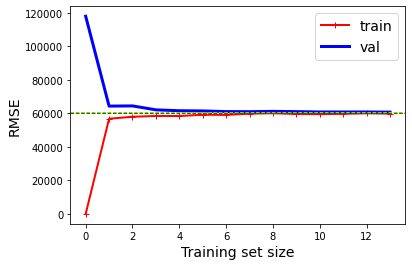

In [49]:
plot_learning_curves(ridge_reg,X_poly,y)

Linear Regression has a greater rmse on both training and validation dataset-(Our learning algorithm suffers from high bias and low variance)--> this implies underfitting

Polynomial Regression has low rmse on the training dataset. This implies overfitting

**Ridge Regression neither implies underfitting or overfitting looking at the chart**
